# Introduction <a id='intro'></a>

The telecom operator, Interconnect, would like to forecast churn of their clients or the number of customers disconnecting their service over a given time period. Interconnect would like to ensure loyalty, and offer promotional codes and special plan options for those who are going to leave. The goal is to better understand why customers stay active or churned (terminate their service). Once we have a better idea of why people are leaving, the company can introduce measures to prevent ongoing churn.

The datasets include the plan's contract information, clients' personal data, information on internet services and telephone services.

# Table of Contents

* [Introduction](#intro)
* [Data initialization and preprocessing](#init)
    * [Contract dataset](#contract)
    * [Personal dataset](#personal)
    * [Internet dataset](#internet)
    * [Phone dataset](#phone)
    * [Data preparation](#prep)
* [Exploratory Data Analysis](#eda)
* [Feature Engineering](#featureeng)
* [Model Training](#modeltraining)
* [Model Analysis](#modelanalysis)
* [Conclusions](#conclusions)
* [Report](#report)

## Overview of work
The goal of this work is to develop a model that will predict whether users/clients of the telecom operator, Interconnect, plan to disconnect their service.

We want to classify each client into one of two groups:
1) Loyal customers who don't plan to leave (no churn)
2) Customers who will disconnect their service (churned)

Steps to achieve the goal:
1) Download and inspect the datasets
2) Initial data exploration to determine how the data needs to be preprocessed
3) Perform data preprocessing. This includes:

    a) normalizing column names
    
    b) changing columns to correct data types

    c) checking and removing duplicate entries

    d) merging data sets

    e) treating missing and NaN values
4) Exploratory data analysis (EDA), in-depth analysis on client data
5) Feature engineering to prepare for machine learning models. This includes:

    a) feature encoding (one-hot encoding for categorical features)

    b) feature scaling

    c) fix class imbalance
6) Evaluate and train several different models

    a) Base/dummy model for minimal quality model

    b) Optimize training set for AUC-ROC and accuracy metrics
7) Identify best model and evaluate on validation set
8) Draw conclusions

## Data initialization and preprocessing <a id='init'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [2]:
# Read in datasets
df_contract = pd.read_csv('datasets/contract.csv')
df_personal = pd.read_csv('datasets/personal.csv')
df_internet = pd.read_csv('datasets/internet.csv')
df_phone = pd.read_csv('datasets/phone.csv')

### Contract dataset <a id='contract'></a>

In [3]:
# display info on contract dataset
df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
# target `EndDate`, check for class imbalance
len(df_contract.query("EndDate == 'No'")) / len(df_contract)

0.7346301292063041

<b>Comments on `contract` data</b>
- 7043 entries, no missing values in any columns
- Target: 73% active, 27% inactive meaning class imbalance in data

Tasks for data preparation:
- normalize column naming
- convert columns into proper data types (begindate to datetime, totalcharges to float)
- check for any duplicates
- check for total unique values for features (paperlessbilling, paymentmethod, type)
- feature encoding (type, paperlessbilling, paymentmethod)
- convert target `EndDate` into numerical categories
- fixing class imbalance on `EndDate`

In [5]:
# normalize column naming scheme
df_contract.columns = df_contract.columns.str.lower()

In [6]:
# convert column types
df_contract['begindate'] = pd.to_datetime(df_contract['begindate'], format='%Y-%m-%d')
df_contract['totalcharges'] = pd.to_numeric(df_contract['totalcharges'], errors='coerce')
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   object        
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


There are 11 missing values in the `totalcharges` column

In [7]:
# Check missing values in `totalcharges`
df_contract[df_contract['totalcharges'].isna()]

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


In [8]:
display(df_contract.query("begindate > '2020-01-15'"))
display(df_contract.query("begindate == '2020-01-01'"))

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
33,7310-EGVHZ,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),20.20,20.20
34,3413-BMNZE,2020-01-01,No,Month-to-month,No,Bank transfer (automatic),45.25,45.25
70,2273-QCKXA,2020-01-01,No,Month-to-month,No,Mailed check,49.05,49.05
91,2424-WVHPL,2020-01-01,No,Month-to-month,No,Electronic check,74.70,74.70
...,...,...,...,...,...,...,...,...
6840,1724-IQWNM,2020-01-01,No,Month-to-month,Yes,Mailed check,19.30,19.30
6845,6127-IYJOZ,2020-01-01,No,Month-to-month,Yes,Mailed check,45.85,45.85
6909,9108-EJFJP,2020-01-01,No,Month-to-month,Yes,Mailed check,53.55,53.55
6979,5351-QESIO,2020-01-01,No,Month-to-month,No,Mailed check,24.20,24.20


Missing values occur only on 2020-02-01. Looking at rest of the data, this suggests that the data is current up to this date, and these are users who just signed up for service. Looking at the previous month's data on 2020-01-01, the totalcharges = monthlycharges. Thus, for the missing values, we will assign 0 for totalcharges.

In [9]:
# fill in missing values in totalcharges column
df_contract['totalcharges'] = df_contract['totalcharges'].fillna(0)

In [10]:
# check for duplicates
df_contract.duplicated().sum()

0

In [11]:
# check feature unique values
display(df_contract.nunique())

print(df_contract['type'].unique())
print(df_contract['paperlessbilling'].unique())
print(df_contract['paymentmethod'].unique())

customerid          7043
begindate             77
enddate                5
type                   3
paperlessbilling       2
paymentmethod          4
monthlycharges      1585
totalcharges        6531
dtype: int64

['Month-to-month' 'One year' 'Two year']
['Yes' 'No']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


### Personal dataset <a id='personal'></a>

In [12]:
# display personal dataset info
df_personal.info()
df_personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<b>Comments on `personal` data</b>
- 7043 entries, no missing values in any columns

Tasks for data preparation:
- normalize column naming
- check for any duplicates
- check for total unique values for features (gender, seniorcitizen, partner, dependents)
- feature encoding (gender, partner, dependents)

In [13]:
# normalize column names
df_personal.columns = df_personal.columns.str.lower()

In [14]:
# check feature unique values
display(df_personal.nunique())

print(df_personal['gender'].unique())
print(df_personal['seniorcitizen'].unique())
print(df_personal['partner'].unique())
print(df_personal['dependents'].unique())

customerid       7043
gender              2
seniorcitizen       2
partner             2
dependents          2
dtype: int64

['Female' 'Male']
[0 1]
['Yes' 'No']
['No' 'Yes']


In [15]:
# check duplicates
df_personal.duplicated().sum()

0

### Internet dataset <a id='internet'></a>

In [16]:
# display info on internet
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<b>Comments on `contract` data</b>
- 5517 entries, no missing values in any columns
- Less entries than in contracts/personal datasets

Tasks for data preparation:
- normalize column naming
- check for any duplicates
- check for total unique values for features
- feature encoding
- upon merging with above datasets, will need to address NaN values

In [17]:
# normalize column naming
df_internet.columns = df_internet.columns.str.lower()

In [18]:
# check feature unique values
display(df_internet.nunique())

for col in df_internet:
    print(df_internet[col].unique())

customerid          5517
internetservice        2
onlinesecurity         2
onlinebackup           2
deviceprotection       2
techsupport            2
streamingtv            2
streamingmovies        2
dtype: int64

['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


In [19]:
# check duplicates
df_internet.duplicated().sum()

0

### Phone dataset <a id='phone'></a>

In [20]:
# Display info on phone
df_phone.info()
df_phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<b>Comments on `phone` data</b>
- 6361 entries, no missing values in any columns

Tasks for data preparation:
- normalize column naming
- check for any duplicates
- check for total unique values for features
- feature encoding
- upon merging with above datasets, will need to address NaN values

In [21]:
# column name to lowercase
df_phone.columns = df_phone.columns.str.lower()

In [22]:
# check feature unique values
display(df_phone.nunique())
print(df_phone['multiplelines'].unique())

customerid       6361
multiplelines       2
dtype: int64

['No' 'Yes']


In [23]:
# check duplicates
df_phone.duplicated().sum()

0

### Data preparation <a id='prep'></a>

In [24]:
# merge dataframes
df_merged = df_contract.merge(df_personal, on='customerid', how='outer')
df_merged = df_merged.merge(df_internet, on='customerid', how='outer')
df_merged = df_merged.merge(df_phone, on='customerid', how='outer')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   object        
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   seniorcitizen     7043 non-null   int64         
 10  partner           7043 non-null   object        
 11  dependents        7043 non-null   object        
 12  internetservice   5517 non-null   object        
 13  onlinesecurity    5517 non-null   object        
 14  onlinebackup      5517 n

Expected length of dataframe after merging. Missing values in internet and phone services to default to no services for user.

In [25]:
# Fill NaN in internetservice to None
df_merged['internetservice'] = df_merged['internetservice'].fillna('None')

# Fill rest of missing values to 'No' (user did not sign up for service)
df_merged = df_merged.fillna('No')

## Exploratory Data Analysis <a id='eda'></a>

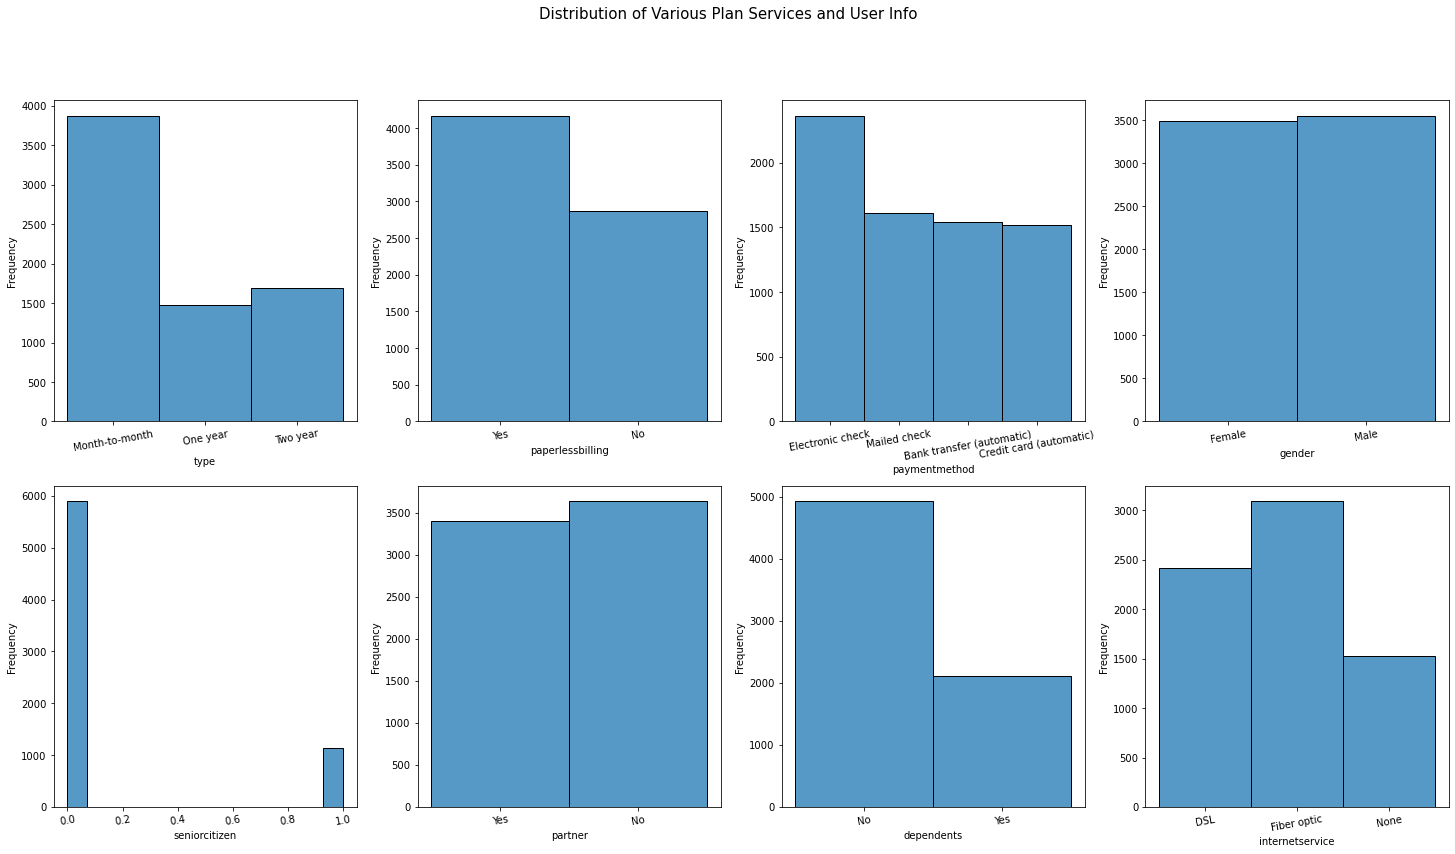

In [26]:
# Look at some histograms
histcols = ['type', 'paperlessbilling', 'paymentmethod', 'gender', 'seniorcitizen', 'partner', 'dependents', 'internetservice']
fig = plt.figure(figsize=(25, 13))
fig.suptitle('Distribution of Various Plan Services and User Info', fontsize=15)
for i, col in enumerate(histcols):
    fig.add_subplot(2, 4, i+1)
    sns.histplot(df_merged[col])
    plt.xlabel(col)
    plt.xticks(rotation=10)
    plt.ylabel('Frequency')
plt.show()

Histogram plots for various service options and patient demographics to get a better idea of the data and how its distributed.

In [27]:
# Check numerical columns for any outliers
df_merged[['monthlycharges', 'totalcharges']].describe()

,monthlycharges,totalcharges
count,7043.000000,7043.000000
mean,64.761692,2279.734304
std,30.090047,2266.794470
min,18.250000,0.000000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


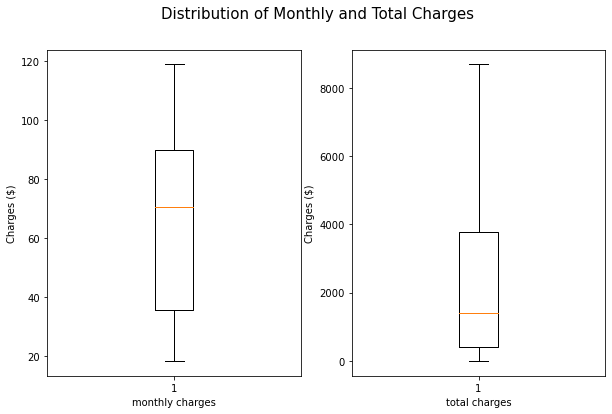

In [28]:
# boxplot visualizations
fig, ax = plt.subplots(1, 2, figsize=(10,6))
fig.suptitle('Distribution of Monthly and Total Charges', fontsize=15)

ax[0].boxplot(df_merged['monthlycharges'])
ax[0].set_xlabel('monthly charges')
ax[0].set_ylabel('Charges ($)')

ax[1].boxplot(df_merged['totalcharges'])
ax[1].set_xlabel('total charges')
ax[1].set_ylabel('Charges ($)')

plt.show()

Data in these columns look fine, no apparent outliers. Monthly charges have a negative skew (mean is less than median), and total charges have a positive skew (mean is greater than the median).

In [29]:
df_merged['enddate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: enddate, dtype: int64

In [30]:
# evaluate the length of churned accounts
terms = df_merged.query("enddate != 'No'")[['begindate', 'enddate']]
terms['enddate'] = pd.to_datetime(terms['enddate'], format='%Y-%m-%d')

In [31]:
# convert to length of service in months
terms['length_months'] = (terms['enddate'] - terms['begindate']) / np.timedelta64(1, 'M')
terms['length_months'] = terms['length_months'].astype('int')

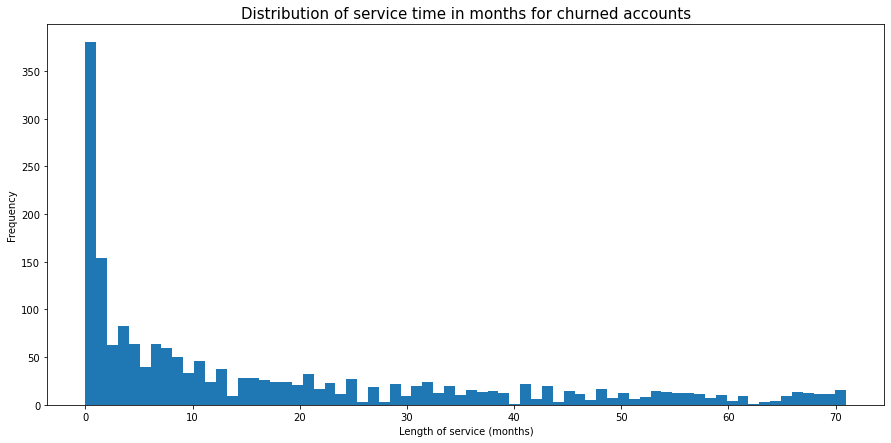

In [32]:
# show histogram of churned accounts and their lengths
plt.figure(figsize=(15, 7))
plt.hist(terms['length_months'], bins=70)
plt.xlabel('Length of service (months)')
plt.ylabel('Frequency')
plt.title('Distribution of service time in months for churned accounts', fontsize=15)
plt.show()

All the terminations have been within these last 4 months (Oct 2019 to present of Feb 2020). The bulk of the terminations are with accounts that are 1 month old.

In [33]:
# Function to create churn/no churn column
def churn(value):
    """
    returns 0 if value is 'No'
    returns 1 if value is a date (churned)
    """
    if value == 'No':
        return 0
    else:
        return 1

In [34]:
# Split into churn/not churn groups
df_merged['churn'] = df_merged['enddate'].apply(churn)

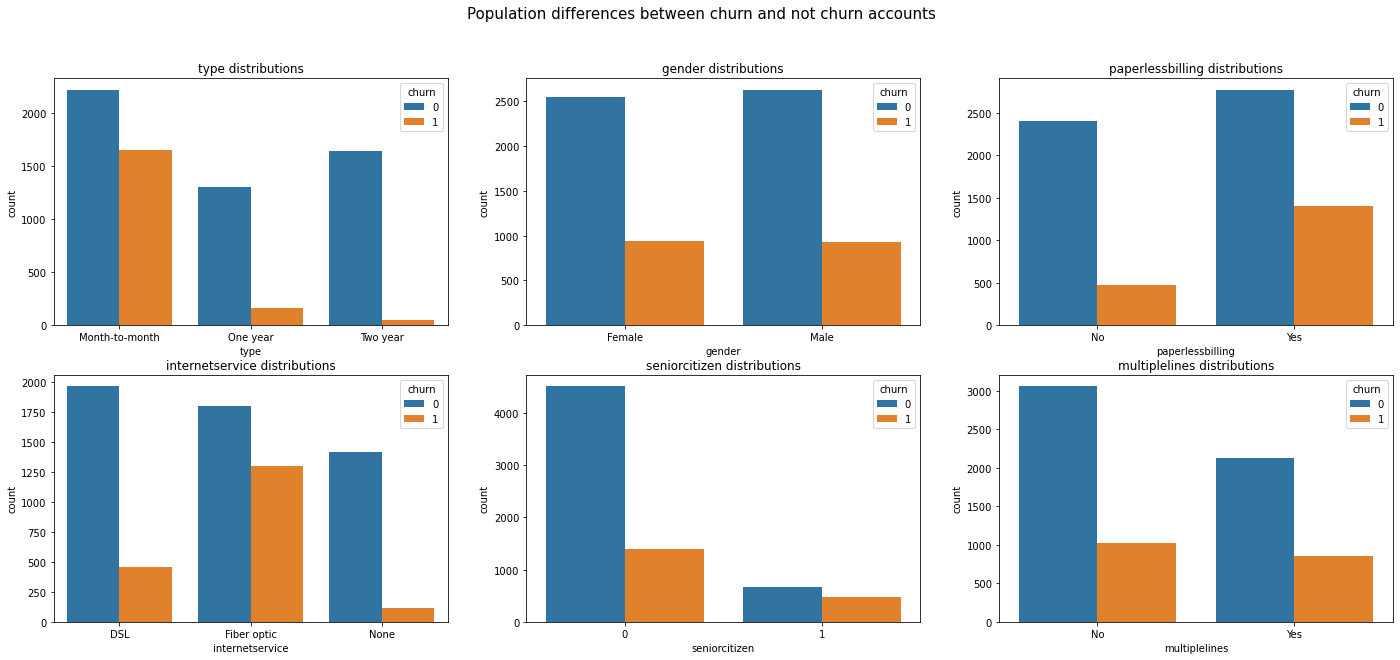

In [35]:
# Evaluate differences in distribution between churn/no groups
cols = ['type', 'gender', 'paperlessbilling', 'internetservice', 'seniorcitizen', 'multiplelines']

fig, axes = plt.subplots(2, 3, figsize=(24, 10))
for i, col in enumerate(cols):
    a = df_merged.groupby(['churn', col]).agg(count=('customerid', 'count')).reset_index()
    j = 0
    if i > 2:
        j = 1
    g = sns.barplot(x=col, y='count', hue='churn', data=a, ax=axes[j, i%3])
    axes[j, i%3].set_title(col + ' distributions')
fig.suptitle('Population differences between churn and not churn accounts', fontsize=15)
plt.show()

We can visualize differences in the distribution of plans and services between the churn and not churn groups.

General trends in gender, senior citizen, paperless billing, or having multiple phone lines appear to not depend much whether it affects if one churns or not churns. Ratio of females to males look identical in both groups. More people enroll in paperless billing in both groups. And less people have multiple phone lines in both groups.

Differences in churn/no churn groups show up on the type of service, and the type of internet service. For service type, the churn group appears to have a higher ratio in the month-to-month plan. For internet service, fiber optic internet is the highest option for people who churn, while in the not churn group, most people use DSL.

## Feature Engineering <a id='featureeng'></a>

In [36]:
# Separate features and target
features = df_merged.copy()
features = features.drop(['customerid', 'enddate', 'churn'], axis=1)
target = df_merged['churn']

Extract year and month values as features from `begindate`

In [37]:
# store year, month in new columns, drop begindate
features['year'] = features['begindate'].dt.year
features['month'] = features['begindate'].dt.month
features = features.drop('begindate', axis=1)

In [38]:
# one hot encoding for categorical columns
features_ohe = pd.get_dummies(features, drop_first=True)

In [39]:
# check encoding
features_ohe.info()
features_ohe.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   monthlycharges                         7043 non-null   float64
 1   totalcharges                           7043 non-null   float64
 2   seniorcitizen                          7043 non-null   int64  
 3   year                                   7043 non-null   int64  
 4   month                                  7043 non-null   int64  
 5   type_One year                          7043 non-null   uint8  
 6   type_Two year                          7043 non-null   uint8  
 7   paperlessbilling_Yes                   7043 non-null   uint8  
 8   paymentmethod_Credit card (automatic)  7043 non-null   uint8  
 9   paymentmethod_Electronic check         7043 non-null   uint8  
 10  paymentmethod_Mailed check             7043 non-null   uint8  
 11  gend

,monthlycharges,totalcharges,seniorcitizen,year,month,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,...,dependents_Yes,internetservice_Fiber optic,internetservice_None,onlinesecurity_Yes,onlinebackup_Yes,deviceprotection_Yes,techsupport_Yes,streamingtv_Yes,streamingmovies_Yes,multiplelines_Yes
0,29.85,29.85,0,2020,1,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
1,56.95,1889.50,0,2017,4,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,53.85,108.15,0,2019,10,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
3,42.30,1840.75,0,2016,5,1,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
4,70.70,151.65,0,2019,9,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0


Splitting data into training, validation, and test sets

In [40]:
# Split OHE dataset into train, validation and test sets (60/20/20)
X_feat, X_test, y_feat, y_test = train_test_split(features_ohe, target, test_size=0.2, random_state=1909)
X_train, X_valid, y_train, y_valid = train_test_split(X_feat, y_feat, test_size=0.25, random_state=1909)

In [41]:
# confirm size of resulting splits
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(4225, 23)
(1409, 23)
(1409, 23)
(4225,)
(1409,)
(1409,)


Scaling numerical data with MinMaxScaler

In [42]:
# Before scaling
X_train[['monthlycharges', 'totalcharges', 'year', 'month']].describe()

,monthlycharges,totalcharges,year,month
count,4225.000000,4225.000000,4225.000000,4225.000000
mean,65.188876,2297.908473,2016.888757,6.408047
std,29.871692,2275.205323,1.972210,3.577885
min,18.250000,0.000000,2013.000000,1.000000
25%,39.600000,399.450000,2015.000000,3.000000
50%,70.600000,1410.250000,2017.000000,6.000000
75%,89.800000,3824.200000,2019.000000,10.000000
max,118.750000,8672.450000,2020.000000,12.000000


In [43]:
# Scale numerical columns (monthlycharge, totalcharge, year, and month)
cols_to_scale = ['monthlycharges', 'totalcharges', 'year', 'month']
scaler = MinMaxScaler().fit(X_train[cols_to_scale])
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_valid[cols_to_scale] = scaler.transform(X_valid[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [44]:
# After scaling on train set
X_train[cols_to_scale].describe()

,monthlycharges,totalcharges,year,month
count,4225.000000,4225.000000,4225.000000,4225.000000
mean,0.467053,0.264966,0.555537,0.491641
std,0.297231,0.262349,0.281744,0.325262
min,0.000000,0.000000,0.000000,0.000000
25%,0.212438,0.046060,0.285714,0.181818
50%,0.520896,0.162613,0.571429,0.454545
75%,0.711940,0.440960,0.857143,0.818182
max,1.000000,1.000000,1.000000,1.000000


Class imbalance fix with upsampling

In [45]:
# Check class imbalance
y_train.value_counts() / len(y_train)

0    0.733254
1    0.266746
Name: churn, dtype: float64

In [46]:
# Synthetic minority over-sampling technique (SMOTE)
oversample = SMOTE()
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

In [47]:
# check resulting of oversampling
y_train_os.value_counts() / len(y_train_os)

1    0.5
0    0.5
Name: churn, dtype: float64

## Model Training <a id='modeltraining'></a>

Function to plot and evaluate models:

In [48]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    """
    Evaluate the given model on the training and test sets, and generate plots for F1 Score, ROC curve, and PR curve.
    """
    eval_stats = {}
    
    # Initialize the figure and subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    # Loop through training and test sets
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        eval_stats[type] = {}
    
        # Generate predictions and probabilities
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # Compute F1 scores for various thresholds
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # Compute ROC curve and AUC
        fpr, tpr, roc_thresholds = roc_curve(target, pred_proba)
        roc_auc = roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC-AUC'] = roc_auc

        # Compute PR curve and APS
        precision, recall, pr_thresholds = precision_recall_curve(target, pred_proba)
        aps = average_precision_score(target, pred_proba)
        
        # Set the color for the plot
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Plot the F1 score curve
        ax = axs[0]
        # Find index of the maximum F1 score
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # Plot the ROC curve
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC-AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # Plot the precision recall surve
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(3)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'ROC-AUC'))
    
    print(df_eval_stats)
    
    return

Dummy minimal quality model

          train   test
Accuracy  0.509  0.515
F1        0.504  0.343
ROC-AUC   0.500  0.500


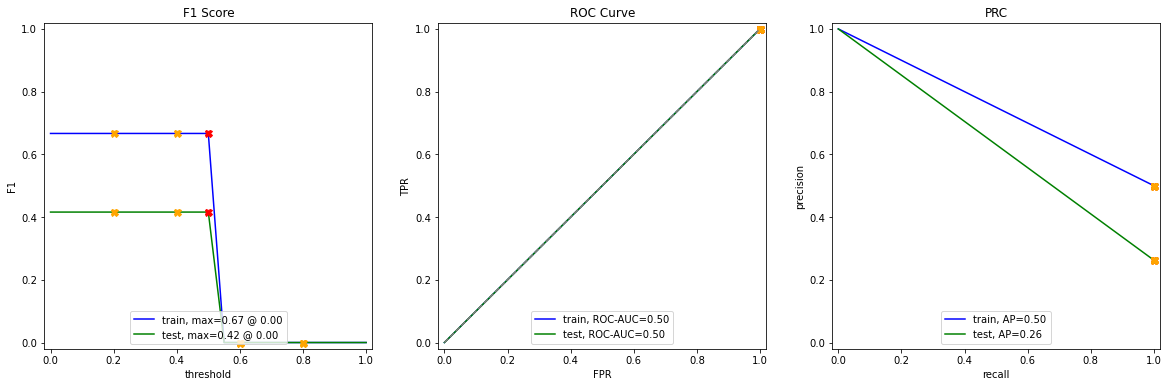

In [49]:
# dummy model - minimal model
model_dummy = DummyClassifier(random_state=1909, strategy='uniform')
model_dummy.fit(X_train_os, y_train_os)

evaluate_model(model_dummy, X_train_os, y_train_os, X_valid, y_valid)

Dummy model with AUC-ROC of 0.5. Predictions is the same as guessing.

Logistic Regression

In [50]:
# finding best logistic regression tuning with validation set
best_rocauc_LR = 0
best_f1_LR = 0
best_solver_LR = ''
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
for solv in solvers:
    model_LR = LogisticRegression(random_state=1909, solver=solv).fit(X_train_os, y_train_os)
    prediction_LR = model_LR.predict(X_valid)
    prediction_proba_LR = model_LR.predict_proba(X_valid)[:, 1]
    f1_sc = f1_score(y_valid, prediction_LR)
    rocauc = roc_auc_score(y_valid, prediction_proba_LR)
    if rocauc > best_rocauc_LR:
        best_rocauc_LR = rocauc
        best_f1_LR = f1_sc
        best_solver_LR = solv

# Run best model
model_LR = LogisticRegression(random_state=1909, solver=best_solver_LR).fit(X_train_os, y_train_os)

In [51]:
print(f'AUC-ROC: {best_rocauc_LR}')
print(f'F1: {best_f1_LR}')
print(f'Params: solver: {best_solver_LR}')

AUC-ROC: 0.8346773144655724
F1: 0.6079295154185022
Params: solver: liblinear


          train   test
Accuracy  0.782  0.747
F1        0.790  0.608
ROC-AUC   0.866  0.835


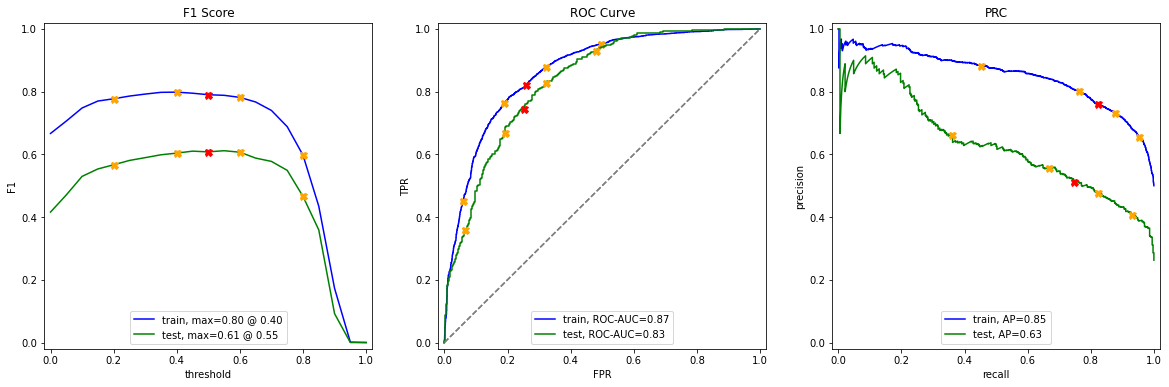

In [52]:
evaluate_model(model_LR, X_train_os, y_train_os, X_valid, y_valid)

Decent AUC-ROC score on the validation set of 0.835, better than guessing and has predictive qualities. Overfitting is observed.

Random Forest

In [53]:
# finding best random forest tuning with validation set
best_rocauc_RF = 0
best_f1_RF = 0
best_est_RF = 0
best_maxdepth_RF = 0
for depths in range(1, 11):
    for nest in range(25, 201, 25):
        model_RF = RandomForestClassifier(random_state=1909, n_estimators=nest, max_depth=depths).fit(X_train_os, y_train_os)
        prediction_RF = model_RF.predict(X_valid)
        prediction_proba_RF = model_RF.predict_proba(X_valid)[:, 1]
        f1_sc = f1_score(y_valid, prediction_RF)
        rocauc = roc_auc_score(y_valid, prediction_proba_RF)
        if rocauc > best_rocauc_RF:
            best_rocauc_RF = rocauc
            best_f1_RF = f1_sc
            best_est_RF = nest
            best_maxdepth_RF = depths

# Run best model
model_RF = RandomForestClassifier(random_state=1909, n_estimators=best_est_RF, max_depth=best_maxdepth_RF).fit(X_train_os, y_train_os)

In [54]:
print(f'AUC-ROC: {best_rocauc_RF}')
print(f'F1: {best_f1_RF}')
print(f'Params: n_estimators: {best_est_RF}, max_depth: {best_maxdepth_RF}')

AUC-ROC: 0.8679343443539786
F1: 0.65
Params: n_estimators: 175, max_depth: 10


          train   test
Accuracy  0.909  0.791
F1        0.913  0.650
ROC-AUC   0.969  0.868


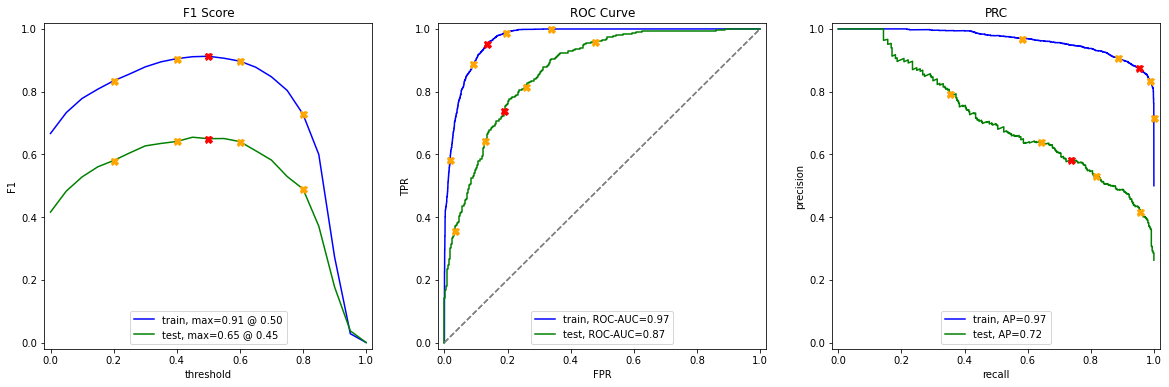

In [55]:
evaluate_model(model_RF, X_train_os, y_train_os, X_valid, y_valid)

Random forest model has better metrics overall compared to the logistic regression model. Again, data is overfitted.

LightGBM

In [56]:
# finding best LightGBM tuning with validation set
best_rocauc_lgb = 0
best_f1_lgb = 0
best_est_lgb = 0
best_maxdepth_lgb = 0
best_numleaves = 0
for depths in range(1, 8):
    for nest in range(100, 251, 25):
        for numl in range(10, 31, 5):
            model_lgb = lgb.LGBMClassifier(random_state=1909, n_estimators=nest, max_depth=depths, num_leaves=numl).fit(X_train_os, y_train_os)
            prediction_lgb = model_lgb.predict(X_valid)
            prediction_proba_lgb = model_lgb.predict_proba(X_valid)[:, 1]
            f1_sc = f1_score(y_valid, prediction_lgb)
            rocauc = roc_auc_score(y_valid, prediction_proba_lgb)
            if rocauc > best_rocauc_lgb:
                best_rocauc_lgb = rocauc
                best_f1_lgb = f1_sc
                best_est_lgb = nest
                best_maxdepth_lgb = depths
                best_numleaves = numl

# Run best model
model_lgb = lgb.LGBMClassifier(random_state=1909, n_estimators=best_est_lgb, max_depth=best_maxdepth_lgb).fit(X_train_os, y_train_os)

In [57]:
print(f'AUC-ROC: {best_rocauc_lgb}')
print(f'F1: {best_f1_lgb}')
print(f'Params: n_estimators: {best_est_lgb}, max_depth: {best_maxdepth_lgb}, num_leaves: {best_numleaves}')

AUC-ROC: 0.9260515568504019
F1: 0.7716763005780345
Params: n_estimators: 250, max_depth: 7, num_leaves: 30


          train   test
Accuracy  0.994  0.888
F1        0.994  0.770
ROC-AUC   1.000  0.925


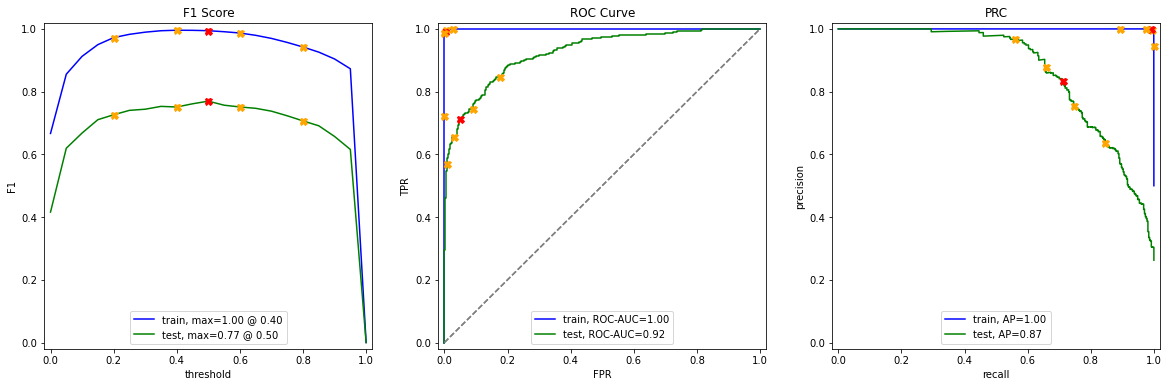

In [58]:
evaluate_model(model_lgb, X_train_os, y_train_os, X_valid, y_valid)

Almost perfect fit to the training data with LightGBM, but overfitted. However, metrics on the validation set is good with AUC-ROC > 0.9.

## Model Analysis <a id='modelanalysis'></a>

LightGBM trained model had the best metrics, so we will evaluate the test set with this model.

In [59]:
prediction_test = model_lgb.predict(X_test)
prediction_proba_test = model_lgb.predict_proba(X_test)[:, 1]
print('Test set metrics')
print('AUC-ROC:', roc_auc_score(y_test, prediction_proba_test))
print('Accuracy:', accuracy_score(y_test, prediction_test))
print('F1 score:', f1_score(y_test, prediction_test))

Test set metrics
AUC-ROC: 0.9309629721798819
Accuracy: 0.8850248403122782
F1 score: 0.767241379310345


          train   test
Accuracy  0.992  0.885
F1        0.984  0.767
ROC-AUC   1.000  0.931


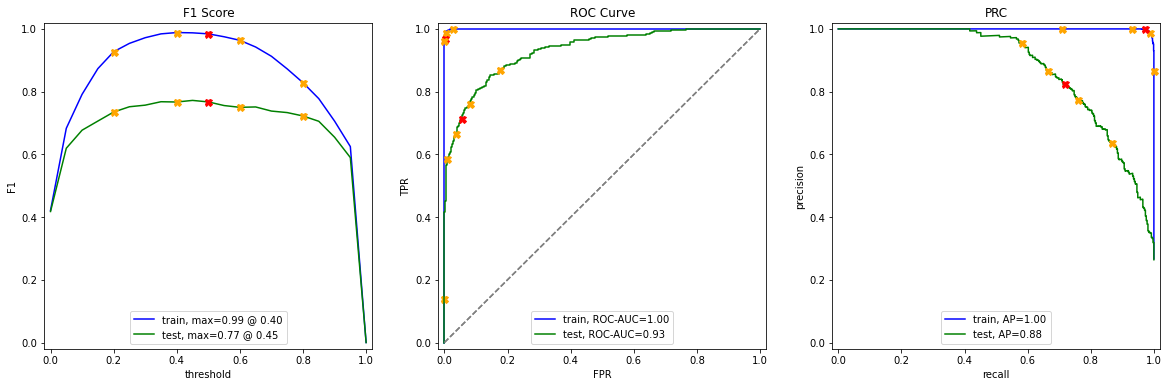

In [60]:
evaluate_model(model_lgb, X_train, y_train, X_test, y_test)

Final metrics on test set:
ROC-AUC = 0.926
Accuracy = 0.881
F1 = 0.761

## Conclusions <a id='conclusions'></a>

A model has been developed with good predictive abilities on predicting whether a user will terminate their service. More specifically, LightGBM was implemented on a binary classification task, to predict on whether users fall into two groups, churned or no churn, with a model accuracy of 88.1% and ROC-AUC of 0.93.

There are some ways that can be explored to improve the model:
- Further hyperparameter tuning should be applied. A few hyperparameters were explored here, and with more compute and time, further improvements can be made and to also improve on overfitting.
- Try other gradient boosting methods with the addition of cross-validation.
- Explore other ways to fix class imbalance. Downsampling or other methods to upsampling can be tested to determine if it improves the prediction metrics.

## Report <a id='report'></a>

<b>Introduction</b>

The purpose of the work is to develop a model that can predict whether a user will terminate their services. The datasets that were used to develop the model are the plan's contract information (start date, end date, billing information), some users' demographic information(gender, senior citizen, partner, dependents), internet plan and services (type of internet and various services), and phone plan (multiple lines). From this information and features, we can develop a model to draw correlation between the user info and plan and how likely they will churn.

<b>Methodology</b>

The first step was to inspect the datasets and clean up for preprocessing. This included standardizing the column names, changing columns to correct data types, and checking for duplicates and missing values. Missing values in the `totalcharges` column of the contract dataset was observed. These were filled with zeros after figuring out the entries are from accounts who have recently signed up and have yet to pay. Next, the datasets were merged together connected by their customer ID. Missing values after the merge will filled by defaulting to assuming that the customer did not sign up for specific service.

In preparation of the dataset for training, a number of steps were performed. The target column for prediction (`enddate` or termination date) was transformed to a binary classification of 0 for no churn, and 1 for churned. Regarding the features, the categorical features were encoded with one-hot encoding and dropping one column to avoid the dummy trap. Year and month data were extracted from `begindate` (account plan starting date). Dataset was then split into training (60%), validation (20%), and test (20%) sets. Numerical features were scaled based on min-max values (MinMaxScaler) on training set, and applied to validation and test sets. It was also decided that to fix class imbalance, upsampling by SMOTE was used. The reason downsampling was avoided as it was not desirable to remove or lose any data that can help with training.

The resulting datasets were trained on several models and the main metrics evaluated were on AUC-ROC and accuracy. These models include logistic regression, random forest, and gradient boosting model (LightGBM), and compared against a minimal quality model. Hyperparameters were tuned on the validation dataset, and the model with the best metrics was used to evaluate on the test set.

<b>Results and Discussion</b>

The best model trained was on a gradient boosting model (LightGBM) resulting in a AUC-ROC of 0.93 and accuracy of 88.1% on the test set. This indicates a model with strong predictive capabilities on whether users will terminate their services.

From the exploratory data analysis, there are a couple points worth further investigation. There is a shift in distribution in the churned group on the plan type (month-to-month, 1-year, 2-year contracts), and the internet service (DSL, fiber optic). Churned group has a higher ratio of plans on the month-to-month, which makes sense since its more likely users here only plan on having the service short term and thus higher churn rates. Fiber optic internet services are heavily favored in the churned group as well. Could there be some issue about the fiber optic internet package that is driving away customers?

The model can be used to predict users who plan to churn and retention incentives can be offered to prevent churning. In order to test the predictive capabilities of the model and effectiveness of the retention offers, I propose the following. Take a group of existing customers, and split the group equally based on prediction of churn/no churn groups. One group is not offered the retention incentive (Group A) while the other group is given the promotions (Group B). Accuracy of the model will be evaluated on Group A, while effectiveness of the promotions will be evaluated by comparing between Group A and Group B.